<a href="https://colab.research.google.com/github/yshivamcodes/air-quality/blob/main/Air_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [93]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (15, 6)

In [94]:
df = pd.read_csv("/content/drive/MyDrive/Delhi_AQI_Dataset.csv", parse_dates=["Date"], dayfirst=True)
df = df.dropna(axis=1, how="all")

<ipython-input-94-19ca93cfc18a>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("/content/drive/MyDrive/Delhi_AQI_Dataset.csv", parse_dates=["Date"], dayfirst=True)


In [95]:
# Feature engineering
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Weekday"] = df["Date"].dt.day_name()

In [96]:
df

,City,Date,AQI,PM2.5,PM10,NO2,SO2,CO,O3,Year,Month,Day,Weekday
0,Delhi,2018-01-01,406,223.30,438.48,336.98,462.84,4.26,385.70,2018,1,1,Monday
1,Delhi,2018-01-02,418,229.90,451.44,346.94,476.52,4.39,397.10,2018,1,2,Tuesday
2,Delhi,2018-01-03,382,210.10,412.56,317.06,435.48,4.01,362.90,2018,1,3,Wednesday
3,Delhi,2018-01-04,366,201.30,395.28,303.78,417.24,3.84,347.70,2018,1,4,Thursday
4,Delhi,2018-01-05,390,214.50,421.20,323.70,444.60,4.10,370.50,2018,1,5,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,Delhi,2024-12-27,353,194.15,381.24,292.99,402.42,3.71,335.35,2024,12,27,Friday
2536,Delhi,2024-12-28,139,76.45,150.12,115.37,158.46,1.46,132.05,2024,12,28,Saturday
2537,Delhi,2024-12-29,225,123.75,243.00,186.75,256.50,2.36,213.75,2024,12,29,Sunday
2538,Delhi,2024-12-30,173,95.15,186.84,143.59,197.22,1.82,164.35,2024,12,30,Monday


In [97]:
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month_name()
df["Day"] = df["Date"].dt.day
df["Season"] = df["Month"].map({
    "December": "Winter", "January": "Winter", "February": "Winter",
    "March": "Summer", "April": "Summer", "May": "Summer",
    "June": "Monsoon", "July": "Monsoon", "August": "Monsoon",
    "September": "Autumn", "October": "Autumn", "November": "Autumn"
})

In [98]:
df

,City,Date,AQI,PM2.5,PM10,NO2,SO2,CO,O3,Year,Month,Day,Weekday,Season
0,Delhi,2018-01-01,406,223.30,438.48,336.98,462.84,4.26,385.70,2018,January,1,Monday,Winter
1,Delhi,2018-01-02,418,229.90,451.44,346.94,476.52,4.39,397.10,2018,January,2,Tuesday,Winter
2,Delhi,2018-01-03,382,210.10,412.56,317.06,435.48,4.01,362.90,2018,January,3,Wednesday,Winter
3,Delhi,2018-01-04,366,201.30,395.28,303.78,417.24,3.84,347.70,2018,January,4,Thursday,Winter
4,Delhi,2018-01-05,390,214.50,421.20,323.70,444.60,4.10,370.50,2018,January,5,Friday,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,Delhi,2024-12-27,353,194.15,381.24,292.99,402.42,3.71,335.35,2024,December,27,Friday,Winter
2536,Delhi,2024-12-28,139,76.45,150.12,115.37,158.46,1.46,132.05,2024,December,28,Saturday,Winter
2537,Delhi,2024-12-29,225,123.75,243.00,186.75,256.50,2.36,213.75,2024,December,29,Sunday,Winter
2538,Delhi,2024-12-30,173,95.15,186.84,143.59,197.22,1.82,164.35,2024,December,30,Monday,Winter


In [99]:
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
                                Date          AQI        PM2.5         PM10  \
count                           2540  2540.000000  2540.000000  2540.000000   
mean   2021-06-29 19:39:46.771653632   212.410630   116.825846   229.403480   
min              2018-01-01 00:00:00    41.000000    22.550000    44.280000   
25%              2019-09-27 18:00:00   118.000000    64.900000   127.440000   
50%              2021-06-24 12:00:00   196.500000   108.075000   212.220000   
75%              2023-04-06 06:00:00   298.000000   163.900000   321.840000   
max              2024-12-31 00:00:00   494.000000   271.700000   533.520000   
std                              NaN   107.769594    59.273277   116.391162   

               NO2          SO2           CO           O3         Year  \
count  2540.000000  2540.000000  2540.000000  2540.000000  2540.000000   
mean    176.300823   242.148118     2.230579   201.790098  2020.994882   
min      34.030000    46.740000     0.430000  

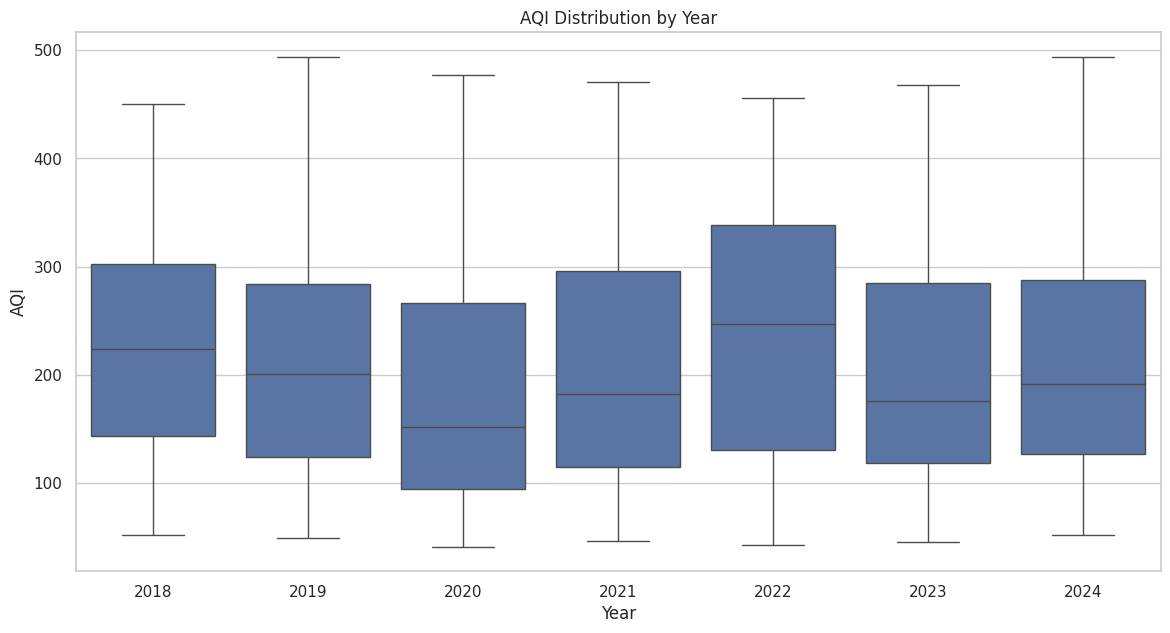

In [100]:
plt.figure(figsize=(14, 7))
sns.boxplot(x="Year", y="AQI", data=df)
plt.title("AQI Distribution by Year")
plt.show()

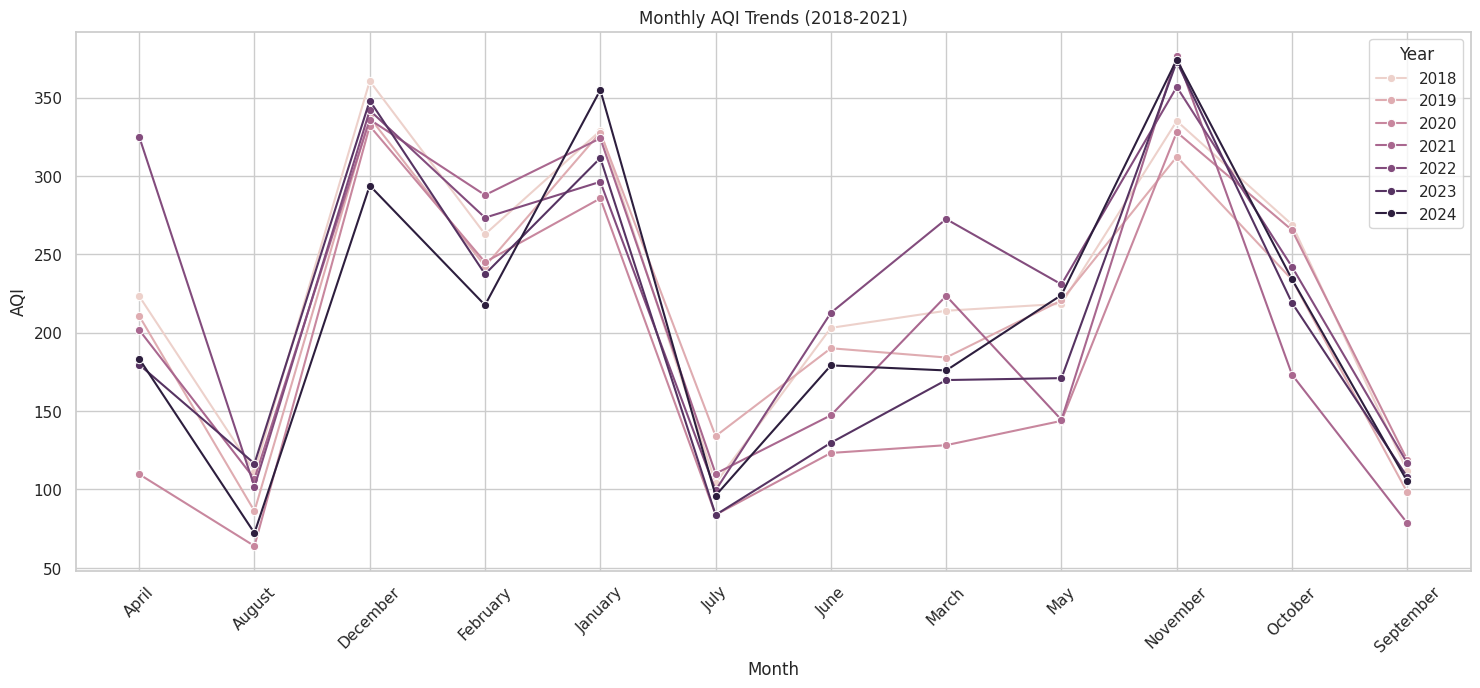

In [101]:
# Monthly trends
monthly_avg = df.groupby(["Year", "Month"]).agg({"AQI": "mean"}).reset_index()
plt.figure(figsize=(18, 7))
sns.lineplot(x="Month", y="AQI", hue="Year", data=monthly_avg, marker="o")
plt.title("Monthly AQI Trends (2018-2021)")
plt.xticks(rotation=45)
plt.show()

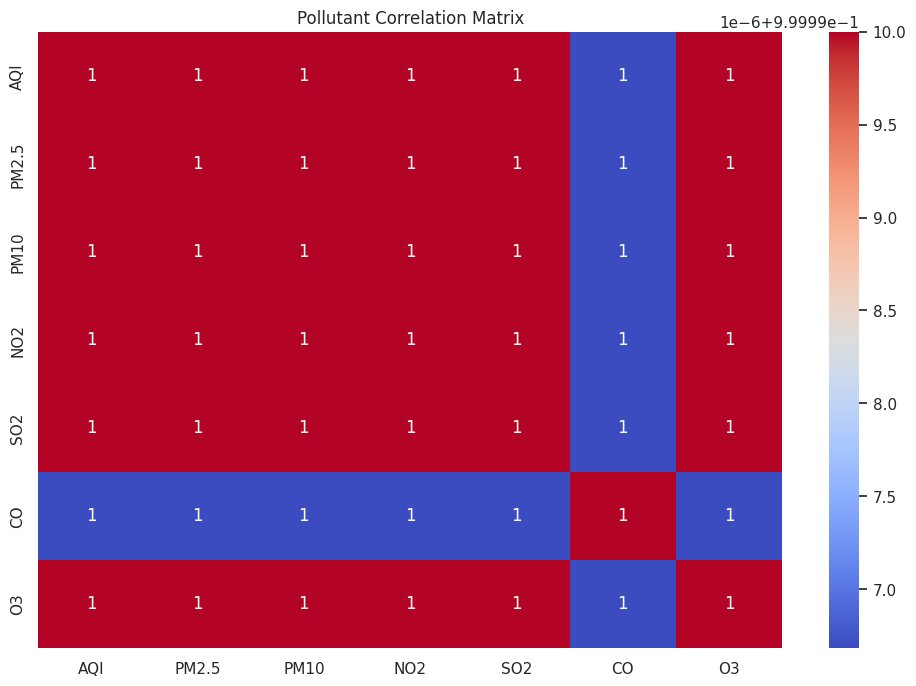

In [102]:
# Pollutant correlation matrix
corr_matrix = df[["AQI", "PM2.5", "PM10", "NO2", "SO2", "CO", "O3"]].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Pollutant Correlation Matrix")
plt.show()

In [103]:
# Prepare data for Prophet
prophet_df = df[["Date", "AQI"]].rename(columns={"Date": "ds", "AQI": "y"})

In [104]:
prophet_df

,ds,y
0,2018-01-01,406
1,2018-01-02,418
2,2018-01-03,382
3,2018-01-04,366
4,2018-01-05,390
...,...,...
2535,2024-12-27,353
2536,2024-12-28,139
2537,2024-12-29,225
2538,2024-12-30,173


In [105]:
# Split data
train_size = int(len(prophet_df) * 0.8)
train = prophet_df[:train_size]
test = prophet_df[train_size:]

In [106]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="multiplicative"
)
model.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpuincx8dm/0ual1p8w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuincx8dm/si3e35kg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64216', 'data', 'file=/tmp/tmpuincx8dm/0ual1p8w.json', 'init=/tmp/tmpuincx8dm/si3e35kg.json', 'output', 'file=/tmp/tmpuincx8dm/prophet_modeliuvzbkt9/prophet_model-20250502202704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:27:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [107]:
# Create future dataframe
future = model.make_future_dataframe(periods=len(test), freq="D")

In [108]:
# Generate forecast
forecast = model.predict(future)

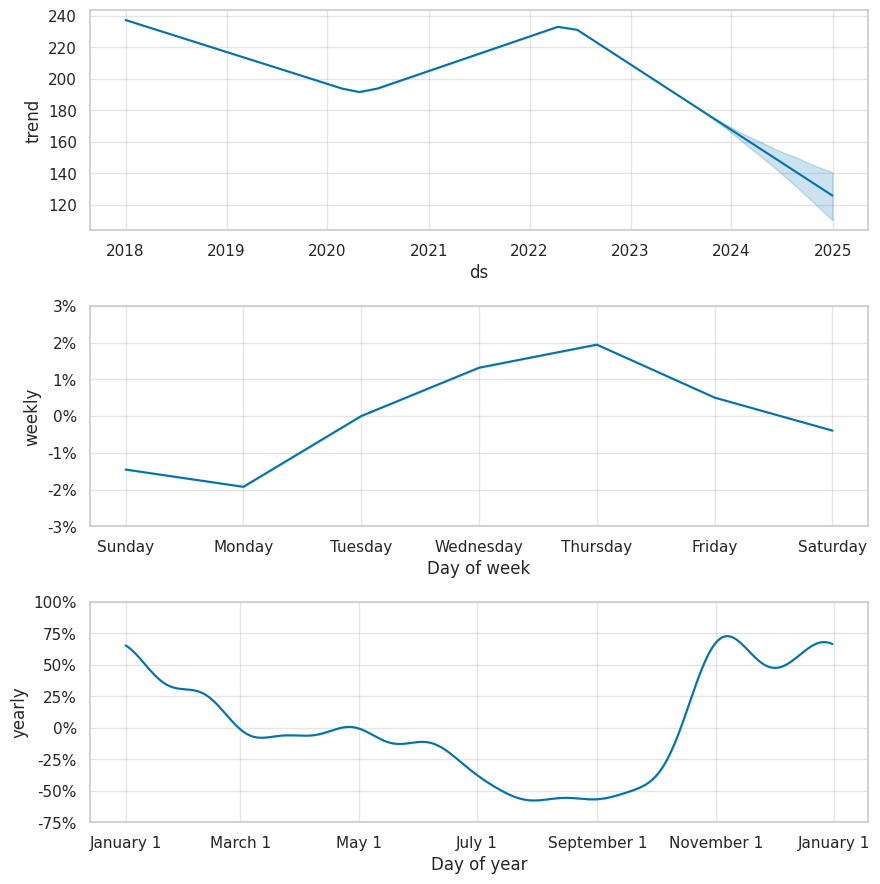

In [109]:
# Plot components
fig = model.plot_components(forecast)
plt.show()

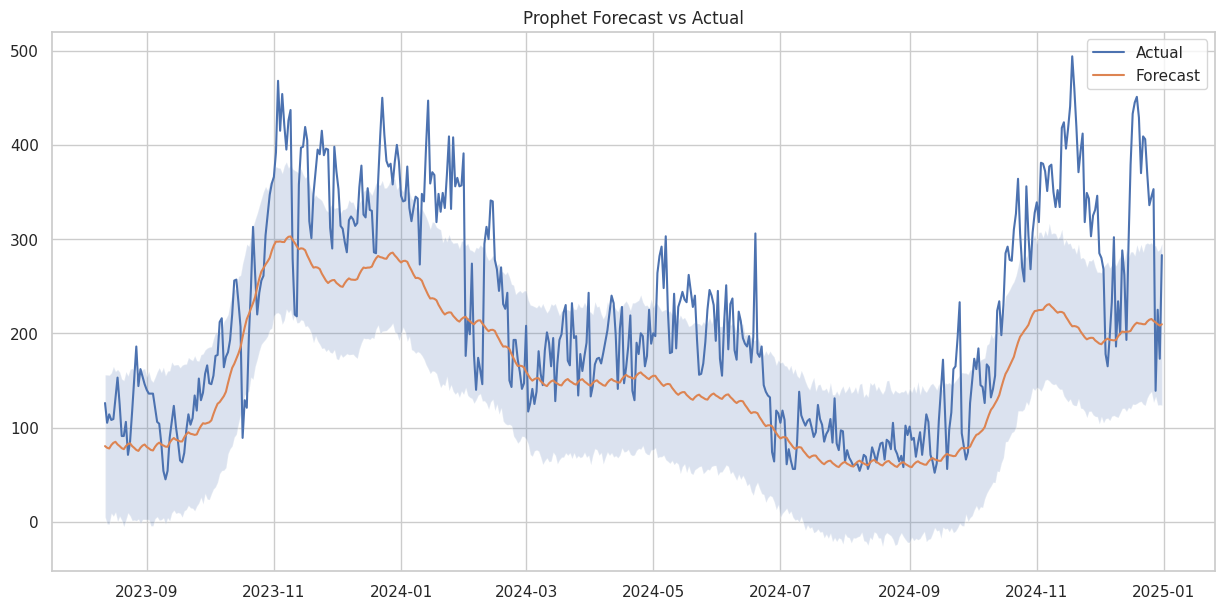

In [110]:
# Plot forecast vs actual
plt.figure(figsize=(15, 7))
plt.plot(test["ds"], test["y"], label="Actual")
plt.plot(forecast["ds"][-len(test):], forecast["yhat"][-len(test):], label="Forecast")
plt.fill_between(
    test["ds"],
    forecast["yhat_lower"][-len(test):],
    forecast["yhat_upper"][-len(test):],
    alpha=0.2
)
plt.title("Prophet Forecast vs Actual")
plt.legend()
plt.show()

In [111]:
# calculat metrics
rmse = np.sqrt(mean_squared_error(test["y"], forecast["yhat"][-len(test):]))
mae = mean_absolute_error(test["y"], forecast["yhat"][-len(test):])
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 84.87845139200627
MAE: 66.75607631698855


In [112]:
#now XG Boost will be used for trend analysis

In [113]:
# creating features
def create_features(df):
    df["lag_7"] = df["AQI"].shift(7)
    df["rolling_7_mean"] = df["AQI"].rolling(7).mean()
    return df

df = create_features(df).dropna()

In [114]:
# spliting data
X = df[["lag_7", "rolling_7_mean", "Month", "Day"]]
y = df["AQI"]

# Convert 'Month' column to numerical representation (e.g., month numbers 1-12)
X['Month'] = X['Month'].map({month: i for i, month in enumerate(df['Month'].unique(), 1)})


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


<ipython-input-114-28cedc1f6890>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Month'] = X['Month'].map({month: i for i, month in enumerate(df['Month'].unique(), 1)})


In [115]:
# Train model
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    objective="reg:squarederror"
)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [116]:
# Predictions
xgb_pred = xgb.predict(X_test)


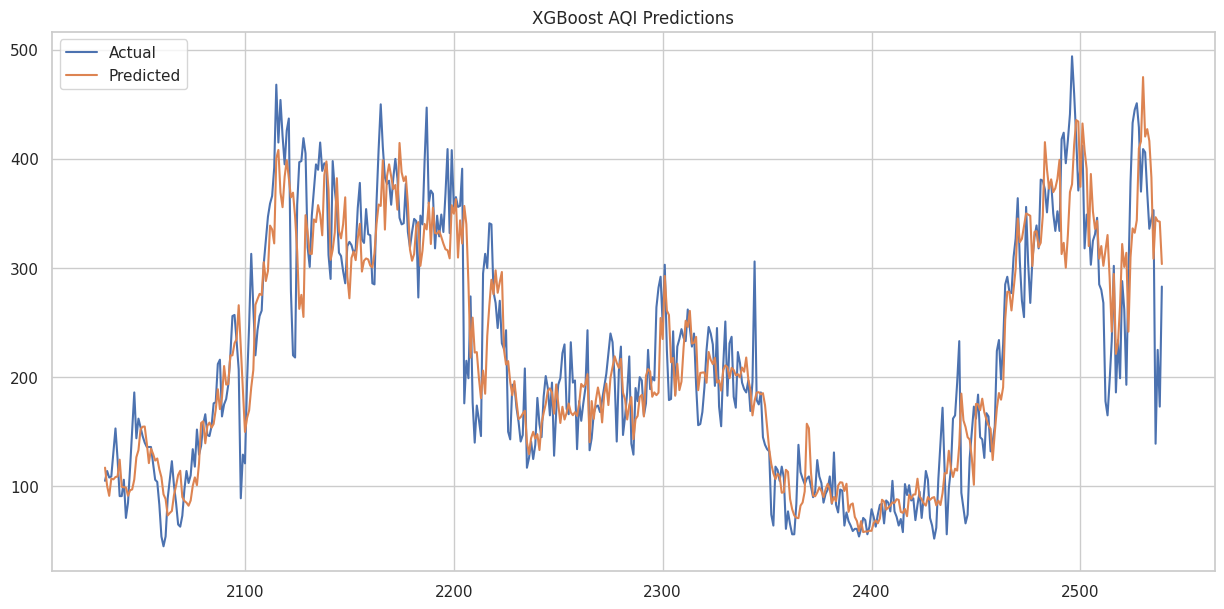

XGBoost RMSE: 46.31962137387082
XGBoost MAE: 33.511226654052734


In [117]:
#now evaluation
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, xgb_pred, label="Predicted")
plt.title("XGBoost AQI Predictions")
plt.legend()
plt.show()

print(f"XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"XGBoost MAE: {mean_absolute_error(y_test, xgb_pred)}")

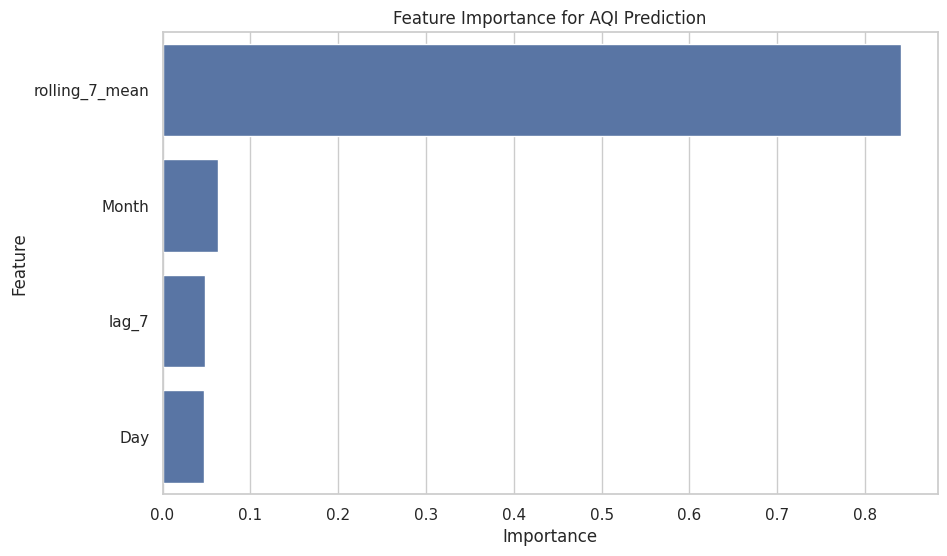

In [118]:
# Feature importance
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Feature Importance for AQI Prediction")
plt.show()

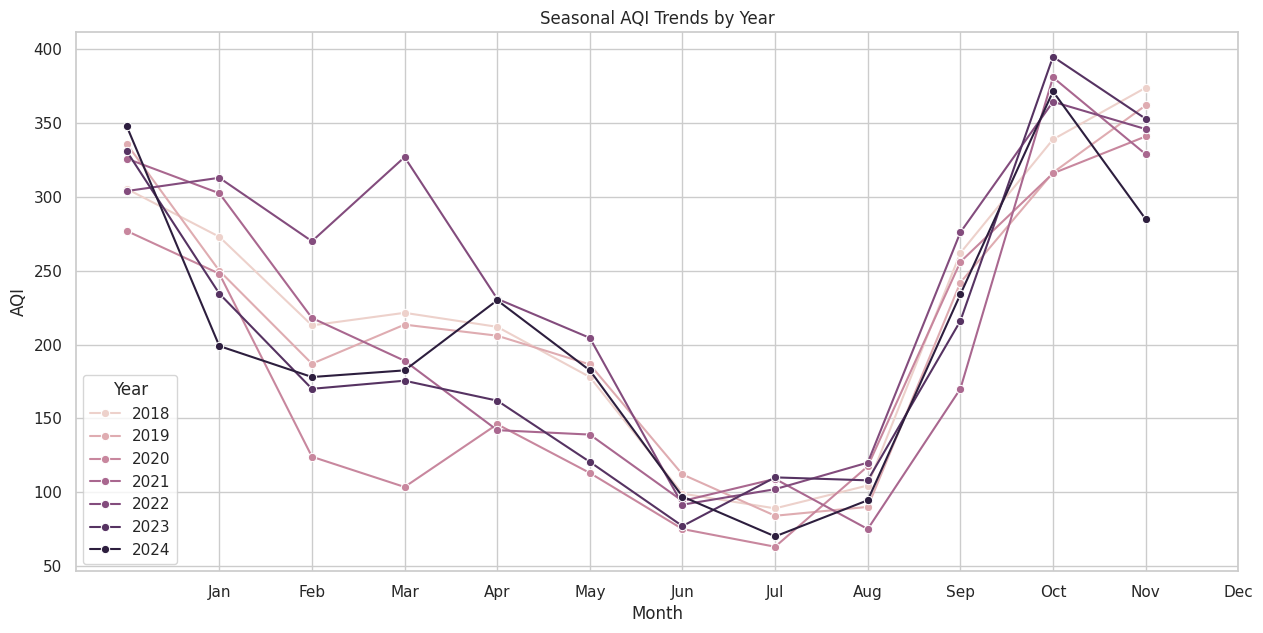

In [119]:
# seasonal plot 2018-24
plt.figure(figsize=(15, 7))
sns.lineplot(
    x="Month",
    y="AQI",
    hue="Year",
    data=df,
    estimator="median",
    errorbar=None,
    marker="o"
)
plt.title("Seasonal AQI Trends by Year")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

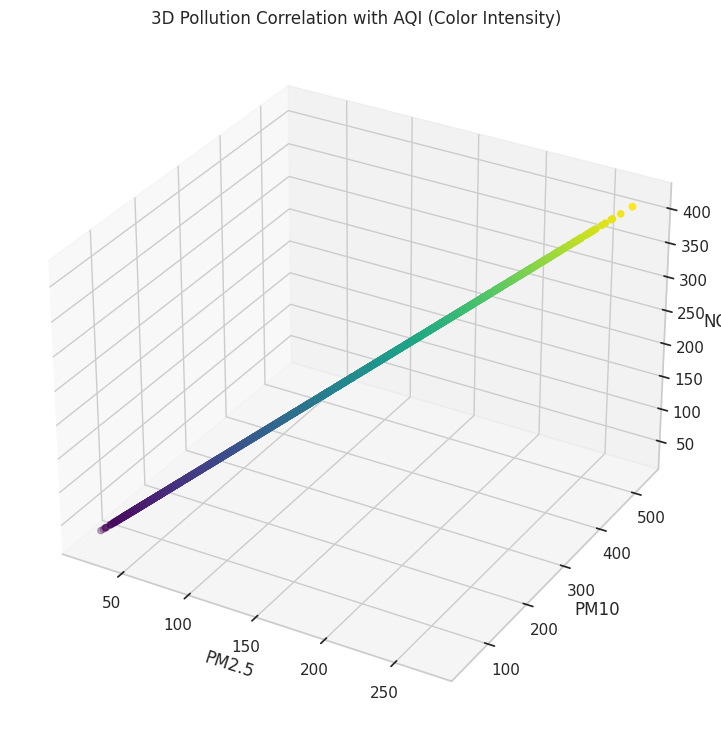

In [120]:
# 3D Pollution Analysis
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    df["PM2.5"],
    df["PM10"],
    df["NO2"],
    c=df["AQI"],
    cmap="viridis"
)
ax.set_xlabel("PM2.5")
ax.set_ylabel("PM10")
ax.set_zlabel("NO2")
plt.title("3D Pollution Correlation with AQI (Color Intensity)")
plt.show()

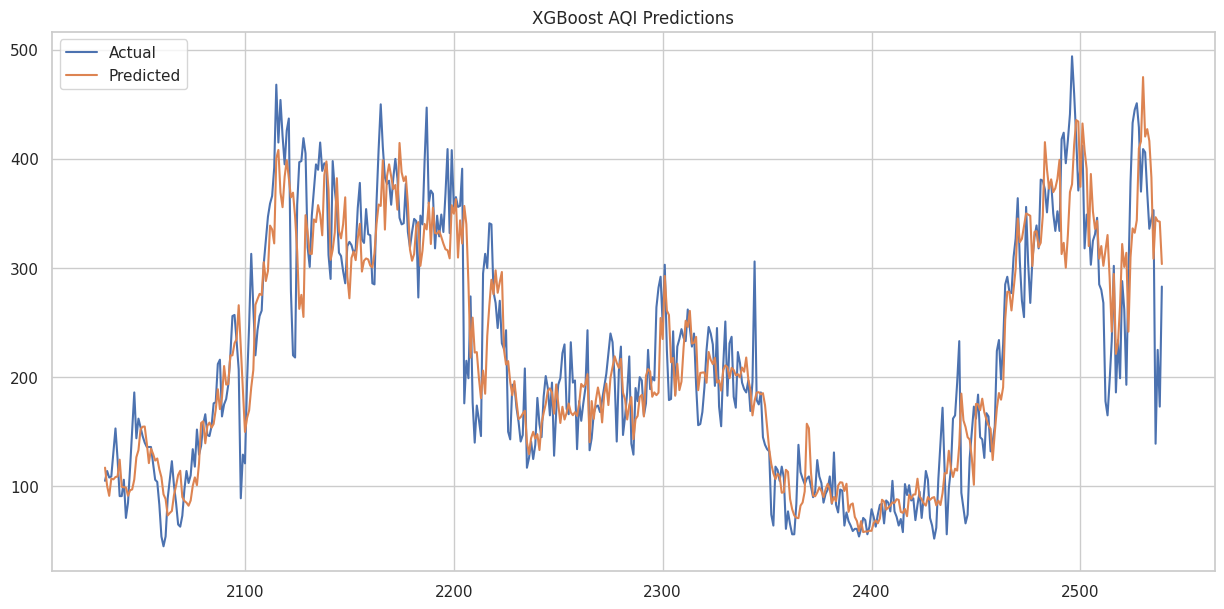

XGBoost RMSE: 46.31962137387082
XGBoost MAE: 33.511226654052734
XGBoost R-squared: 0.8229613304138184


In [121]:
from sklearn.metrics import accuracy_score

#now evaluation
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, xgb_pred, label="Predicted")
plt.title("XGBoost AQI Predictions")
plt.legend()
plt.show()

print(f"XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"XGBoost MAE: {mean_absolute_error(y_test, xgb_pred)}")


#Calculate R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, xgb_pred)
print(f"XGBoost R-squared: {r2}")
